In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("rainbow")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
plt.rcParams.update({'font.size': 10})

In [4]:
data_path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
columns = 'age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target'.split(',')

heart_disease = pd.read_csv(data_path, names=columns)
print(f'Rows: {heart_disease.shape[0]}\nColumns: {heart_disease.shape[1]}')
#print(heart_disease.dtypes)
heart_disease.head()

Rows: 303
Columns: 14


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Το clustering θεωρείται κομμάτι του unsupervised learning, δηλαδή έχουμε τα δεδομένα Χ για τα οποία δεν μας δίνεται καμία πληροφορία για τις ετικέτες τους, και καλούμαστε να τα χωρίσουμε σε clusters τα οποία περιγράφουν τη δομή των δεδομένων μας (ιδανικά, θα αντιστοιχίζονται στην μεταβλητή y).     

Συνεπώς, για να προχωρήσουμε σε συσταδοποίηση, θα πρέπει να αφαιρέσουμε από το dataset την μεταβλητή target, καθώς όπως είπαμε σε ένα clustering project δεν γνωρίζουμε ποτέ τα labels των δεδομένων μας. 

In [5]:
target = heart_disease['target']
heart_disease = heart_disease.drop('target', axis=1)

In [6]:
target = target.map(lambda x: 0 if x == 0 else 1)

Θα χρησιμοποιήσω την μεταβλητή y(target) μόνο για να αξιολογήσω το μοντέλο μου στο τέλος, και όχι για να το εκπαιδεύσω. 

# Part 1 and 2 

In [7]:
#Missing Values : Replace '?' with None
for column in heart_disease.select_dtypes('object'):
    heart_disease[column] = heart_disease[column].replace('?', np.nan).astype(float)

#Fill in None with most frequent value
heart_disease["ca"] = heart_disease["ca"].fillna(heart_disease['ca'].mode()[0])
heart_disease["thal"] = heart_disease["thal"].fillna(heart_disease['thal'].mode()[0])

#Turn object type into integers
heart_disease['ca'] = heart_disease['ca'].astype(float).astype(int)
heart_disease['thal'] = heart_disease['thal'].astype(float).astype(int)

## Standardization 

In [8]:
columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()
heart_disease.loc[:,columns] = scaler.fit_transform(heart_disease.loc[:,columns]) #this gives us back a dataframe

In [9]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,1.0,1.0,0.757525,-0.264900,1.0,2.0,0.017197,0.0,1.087338,3.0,-0.711131,6
1,1.392002,1.0,4.0,1.611220,0.760415,0.0,2.0,-1.821905,1.0,0.397182,2.0,2.504881,3
2,1.392002,1.0,4.0,-0.665300,-0.342283,0.0,2.0,-0.902354,1.0,1.346147,2.0,1.432877,7
3,-1.932564,1.0,3.0,-0.096170,0.063974,0.0,0.0,1.637359,0.0,2.122573,3.0,-0.711131,3
4,-1.489288,0.0,2.0,-0.096170,-0.825922,0.0,2.0,0.980537,0.0,0.310912,1.0,-0.711131,3


# Part 4

## KMeans 

Τώρα τα δεδομένα μας είναι στην σωστή μορφή για να συσταδοποιηθούν. Εκτιμούμε πως ο βέλτιστος αριθμός των συστάδων θα είναι ανάμεσα στο 2 και στο 5, όπως δηλαδή κατανέμονται και οι τιμές της target. Για να αποφασίσουμε ποιο k είναι το ιδανικό, θα πραγματοποιήσουμε ένα for loop για το k, δοκιμάζοντας τις τιμές από k=2 μέχρι k=10. Για να αξιολογήσουμε την αποτελεσματικότητα του αλγορίθμου για τα διαφορετικά k, θα υπολογίσουμε για το καθένα το silhouette score του. To silhouette score παίρνει τιμές από το 1 έως το -1, και όσο πιο κοντά βρίσκεται στο 1, τόσο πιο καλά έχουν κατανεμηθεί οι συστάδες μας. 

In [10]:
sil_score =[]
for k in range(2,11):
    cluster = KMeans(n_clusters=k).fit(heart_disease)
    print(silhouette_score(heart_disease, cluster.labels_ ))
    sil_score.append(silhouette_score(heart_disease, cluster.labels_ ))

0.3103211089162096
0.20651671318364356
0.16190528129533263
0.15554291280802582
0.13262673344029324
0.1364538611640362
0.13315053892412532
0.11656729823308871
0.13991648127293294


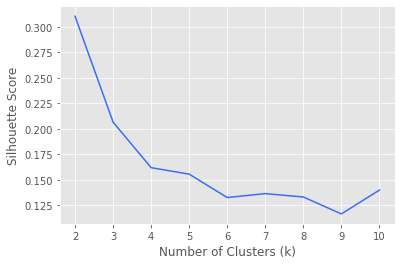

In [11]:
sns.lineplot(x = range(2,11),y = sil_score);
plt.ylabel('Silhouette Score');
plt.xlabel('Number of Clusters (k)');

Βλέπουμε πως για k=2, ο αλγόριθμος KMeans μας δίνει το υψηλότερο silhouette_score. Επομένως, θα χρησιμοποιήσουμε αυτόν για να χωρίσουμε τα δεδομένα μας σε clusters. 

In [12]:
cluster = KMeans(n_clusters=2).fit(heart_disease)
print(silhouette_score(heart_disease, cluster.labels_ ))

0.3103211089162096


In [13]:
print(cluster.cluster_centers_)
print(cluster.labels_)
#Βλέπουμε πως τα δεδομένα μας αντιστοιχίζονται είτε στον cluster με label 0, είτε στον cluster με label 2. 

[[-1.18564685e-01  5.17857143e-01  2.93452381e+00 -1.25303835e-01
  -5.80777705e-03  1.25000000e-01  9.64285714e-01  2.56207693e-01
   1.90476190e-01 -3.09920633e-01  1.43452381e+00 -2.32558159e-01
   3.00000000e+00]
 [ 1.47547163e-01  8.81481481e-01  3.43703704e+00  1.55933661e-01
   7.22745588e-03  1.77777778e-01  1.02222222e+00 -3.18836240e-01
   4.96296296e-01  3.85679010e-01  1.80740741e+00  2.89405708e-01
   6.86666667e+00]]
[1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1
 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0
 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0
 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0

In [14]:
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print('Number of iterations: %d' % cluster.n_iter_)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(heart_disease, cluster.labels_ ))
print("Mean Squared Error: %0.3f" % cluster.inertia_)#returns the SSE value

Number of iterations: 3
Estimated number of clusters: 2
Estimated number of noise points: 0
Silhouette Coefficient: 0.310
Mean Squared Error: 2557.302


Θέλουμε να δούμε πως διαφοροποιούνται τα γνωρίσματα του dataset, ανάλογα το cluster στο οποίο έχουν τοποθετηθεί. Για να το κάνουμε αυτό, θα δημιουργήσουμε 2 διαφορετικά dataframes, ένα που περιέχει τα στοιχεία του cluster με ετικέτα 0, και ένα που περιέχει τα στοιχεία του cluster με ετικέτα 1. 

In [15]:
cluster_0 = heart_disease[cluster.labels_==0]
cluster_1 = heart_disease[cluster.labels_==1]

Αν πάρουμε τη μέση τιμή κάθε γνωρίσματος για το κάθε dataframe, μπορούμε να δούμε ποια στοιχεία κάθε στήλης έχουν ανατεθεί σε κάθε cluster.

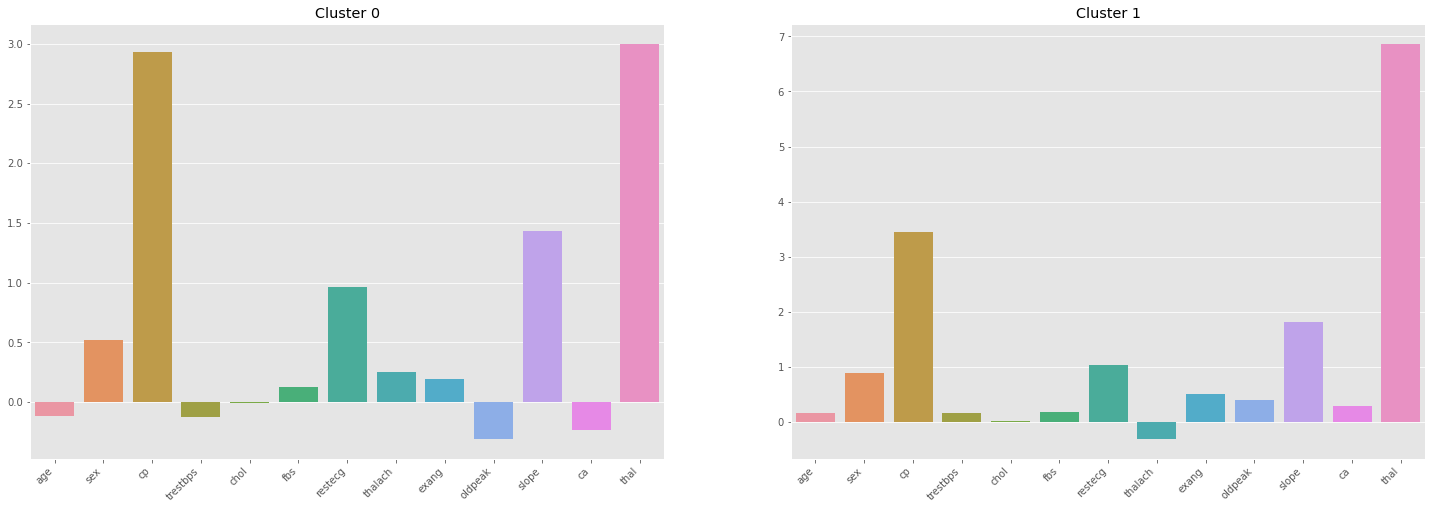

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.barplot(ax=axes[0], x=cluster_0.mean().index, y=cluster_0.mean())
sns.barplot(ax=axes[1], x=cluster_1.mean().index, y=cluster_1.mean())

axes[0].set_title('Cluster 0')
axes[1].set_title('Cluster 1')

axes[0].set_xticklabels(heart_disease.columns, rotation = 45, ha="right");
axes[1].set_xticklabels(heart_disease.columns, rotation = 45, ha="right");

In [17]:
heart_disease.shape

(303, 13)

Μπορούμε να δούμε πως, οι μεταβλητές που παίζουν τον κυριότερο ρόλο στην διαμόρφωση των συστάδων είναι η age, thalach, oldpeak και ca. Ας προσπαθήσουμε τώρα να κάνουμε visualize τα clusters που έφτιαξε ο αλγόριθμός μας, για να δούμε εάν τα όρια του διαχωρισμου των cluster είναι ξεκάθαρα. Το αρχικό σχήμα του dataset μας είναι 303x18, δηλαδή έχει 18 διαστάσεις. Όπως καταλαβαίνουμε, οι 18 διαστάσεις είναι αδύνατο να οπτικοποιηθούν. Έτσι, για να μπορέσουμε να κατανοήσουμε τον τρόπο που δημιουργούνται οι συστάδες, θα πρέπει να μειώσουμε τις διαστάσεις του dataset από 18 σε 2, χρησιμοποιώντας PCA.

In [18]:
pca = PCA(n_components=2)
pca.fit(heart_disease)
decomp = pca.transform(heart_disease)

In [19]:
pca.explained_variance_ratio_

array([0.3550068 , 0.14496351])

In [20]:
decomp.shape

(303, 2)

In [21]:
pca.transform(cluster.cluster_centers_)

array([[-1.79155301,  0.33883983],
       [ 2.22948819, -0.42166734]])

<AxesSubplot:>

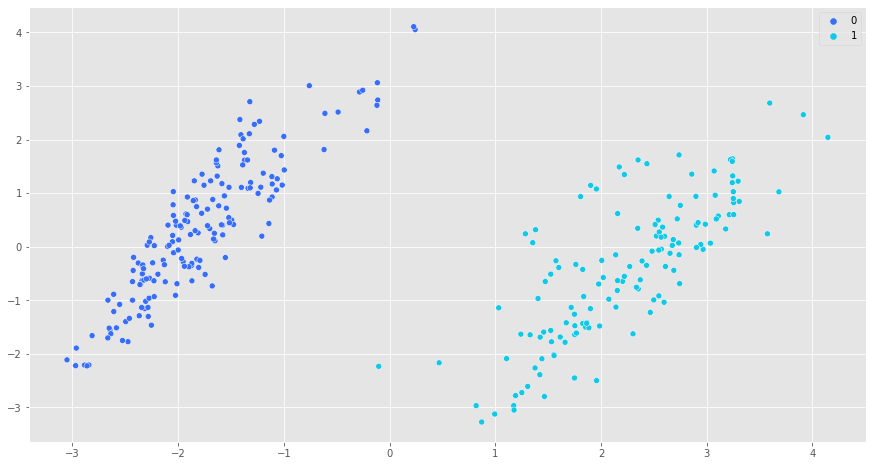

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x= decomp[:,0], y=decomp[:,1], data = decomp, hue =cluster.labels_)

Βλέπουμε πως με το decomposition των δεδομένων μας, είναι πολύ πιο εύκολο να διακρίνουμε πώς χωρίστηκαν σε συσταδες. 

## DBSCAN 

In [23]:
heart_disease.shape

(303, 13)

In [24]:
db = DBSCAN(eps=3,min_samples=5, algorithm='kd_tree', n_jobs=8)
db.fit(heart_disease)
print(silhouette_score(heart_disease, db.labels_ ))

0.2896035847127383


In [25]:
db.labels_

array([ 0,  1,  0,  1,  1,  1,  1,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,
        1,  1,  1,  1,  1,  1,  0,  0,  1,  1, -1,  1,  0,  1,  0,  1,  0,
        1,  1,  0,  0,  0,  1,  0,  0,  1,  1,  1,  0,  1,  0,  1,  1,  1,
        0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  1,  0,
        0,  1,  1,  0,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,
        0,  0,  0,  1, -1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  1,  1,
        0,  0,  0,  1,  1,  0,  1,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1,
        0,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  1,  1,  0,  1,
        0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  1, -1,  1,  1,  0,
       -1,  0,  0,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
        0,  0,  0,  0,  1,  1,  1, -1,  1, -1,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  0,  1,  1

In [26]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(heart_disease, db.labels_))

Estimated number of clusters: 2
Estimated number of noise points: 10
Silhouette Coefficient: 0.290


Όπως και πριν, θέλουμε να δούμε πως διαφοροποιούνται τα γνωρίσματα του dataset, ανάλογα το cluster στο οποίο έχουν τοποθετηθεί. Αυτή τη φορά δημιουργούμε 3 διαφορετικά dataframes, ένα που περιέχει τα στοιχεία του cluster με ετικέτα 0, και ένα που περιέχει τα στοιχεία του cluster με ετικέτα 1, και ένα που περιέχει τα στοιχεία με ετικέτα -1, δηλαδή τον θόρυβο. Αν πάρουμε τη μέση τιμή κάθε γνωρίσματος για το κάθε dataframe, μπορούμε να δούμε ποια στοιχεία κάθε στήλης έχουν ανατεθεί σε κάθε cluster.

In [27]:
cluster_0 = heart_disease[db.labels_==0]
cluster_1 = heart_disease[db.labels_==1]
noise = heart_disease[db.labels_==-1]

In [28]:
cluster_0.mean()

age         0.127974
sex         0.898438
cp          3.476562
trestbps    0.107027
chol       -0.021569
fbs         0.179688
restecg     1.031250
thalach    -0.329687
exang       0.492188
oldpeak     0.304846
slope       1.773438
ca          0.277122
thal        6.867188
dtype: float64

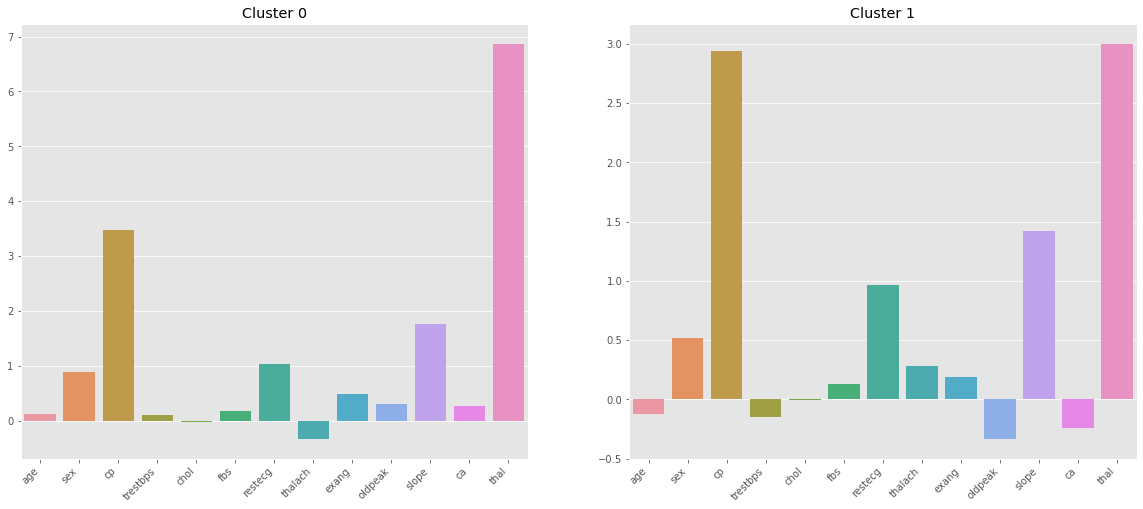

In [29]:
fig, axes = plt.subplots(1,2 , figsize=(20, 8))

sns.barplot(ax=axes[0], x=cluster_0.mean().index, y=cluster_0.mean())
sns.barplot(ax=axes[1], x=cluster_1.mean().index, y=cluster_1.mean())

axes[0].set_title('Cluster 0')
axes[1].set_title('Cluster 1')

axes[0].set_xticklabels(heart_disease.columns, rotation = 45, ha="right");
axes[1].set_xticklabels(heart_disease.columns, rotation = 45, ha="right");

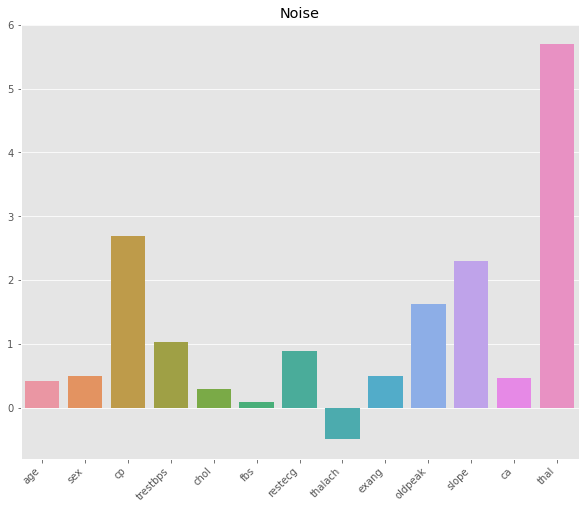

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=noise.mean().index, y=noise.mean())
ax.set_title('Noise')
ax.set_xticklabels(heart_disease.columns, rotation = 45, ha="right");

Οι συστάδες που προκύπτουν είναι 2, και έχουν ετικέτες 0,1. Δέκα παρατηρήσεις δεν ανατέθηκαν σε καμία συστάδα. Αυτά τα σημεία-παρατηρήσεις θεωρούνται θόρυβος, και έχουν ετικέτα -1. Θα κάνουμε πάλι PCA, για να μπορέσουμε να δούμε πώς σχηματίζονται τα δεδομένα μας σε clusters.

In [31]:
pca = PCA(n_components=2)
pca.fit(heart_disease)
decomp = pca.transform(heart_disease)

In [32]:
decomp

array([[ 1.28504021,  0.24105116],
       [ 0.24171835,  4.05521585],
       [ 3.25175996,  1.02756553],
       [-1.67757807, -0.73178637],
       [-2.34217104, -0.63295418],
       [-2.35483465, -0.70256809],
       [-0.28405968,  2.88903518],
       [-1.7778576 ,  0.62488546],
       [ 2.52467226,  0.19993914],
       [ 2.68921363, -0.44027124],
       [ 1.0323981 , -1.1404079 ],
       [-1.69279032,  1.23004999],
       [ 1.35433344,  0.07557528],
       [ 0.81879269, -2.96588648],
       [ 1.61429834, -1.68542909],
       [-1.82278754, -0.23119574],
       [ 1.3069981 , -2.60737452],
       [-1.65178217,  0.11132548],
       [-2.04335181, -0.11260403],
       [-2.36158223, -0.70513899],
       [-1.61615235,  0.76325745],
       [-2.04599405,  1.02940462],
       [-1.67255642,  0.88236473],
       [ 2.4832398 , -0.0825106 ],
       [ 3.11007687,  0.57340211],
       [-1.8724419 , -0.34896236],
       [-2.25843289,  0.17038828],
       [-1.02463748,  1.70025136],
       [-1.80596292,

In [33]:
pca.transform(db.labels_.reshape(-1,1))

array([[-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-4.98741645,  1.11183226],
       [-4.98741645,  1.11183226],
       [-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-4.98741645,  1.11183226],
       [-4.98741645,  1.11183226],
       [-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-4.98741645,  1.11183226],
       [-4.98741645,  1.11183226],
       [-3.07310675,  2.5526861 ],
       [-3.07310675,  2.5526861 ],
       [-6.90172615, -0.32902158],
       [-3.07310675,

<AxesSubplot:>

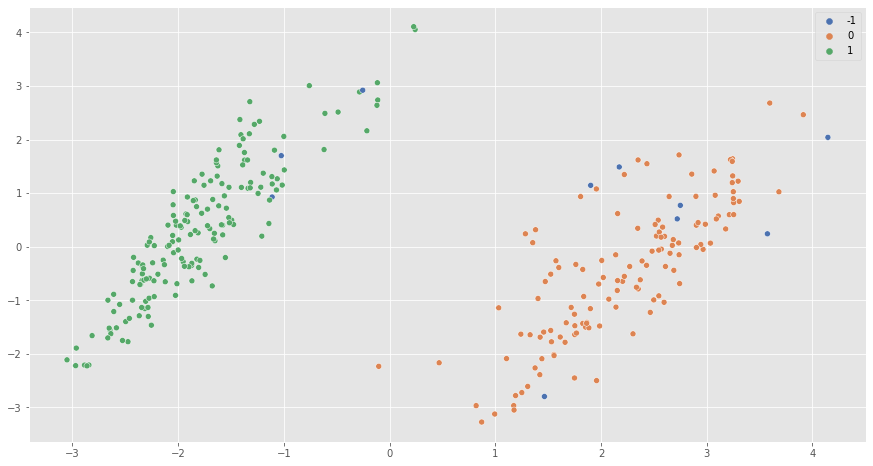

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x= decomp[:,0], y=decomp[:,1], data = decomp, hue =db.labels_, palette="deep")

## Evaluation 

In [35]:
target

0      0
1      1
2      1
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    0
Name: target, Length: 303, dtype: int64

In [36]:
kmeans = pd.Series(cluster.labels_[:,], name='kmeans').astype(int)
dbscan = pd.Series(db.labels_[:,], name='dbscan').astype(int)

In [37]:
pd.crosstab(target, cluster.labels_)

col_0,0,1
target,,
0,130,34
1,38,101


In [38]:
labels = ['no heart disease', 'heart disease']
labels_db = ['noise', 'no heart disease', 'heart disease']

<AxesSubplot:xlabel='kmeans', ylabel='target'>

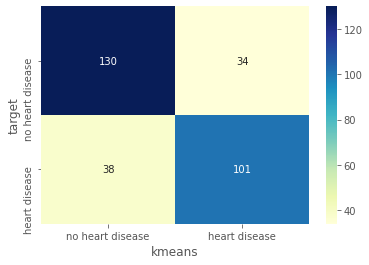

In [39]:
sns.heatmap(pd.crosstab(target, kmeans), 
            cmap="YlGnBu", annot=True, fmt='g',
           xticklabels=labels, yticklabels=labels)

In [40]:
dbscan = dbscan.map(lambda x: 0 if x == 1 else (1 if x == 0 else -1))

In [41]:
pd.crosstab(target, dbscan)

dbscan,-1,0,1
target,,,
0,3,129,32
1,7,36,96


<AxesSubplot:xlabel='dbscan', ylabel='target'>

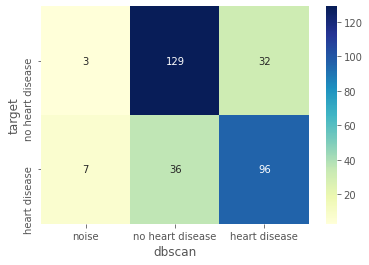

In [42]:
sns.heatmap(pd.crosstab(target, dbscan), cmap="YlGnBu", annot=True, fmt='g',
           xticklabels=labels_db, yticklabels=labels)